# Hand Gesture Recognition using small HGR1 dataset with ResNet and Transfer Learning

+ Author: lds217
+ Date: $13^{th}$, Nov, $2024$

## Data Set
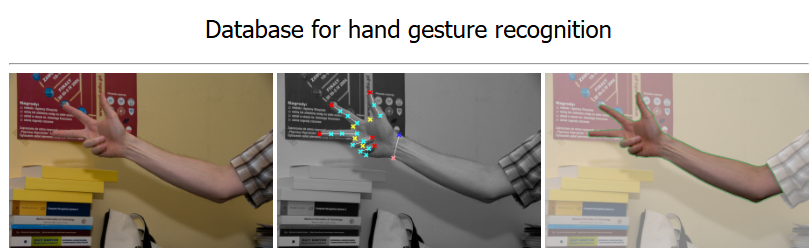

HGR1:
+ Number of images: 899.
+ Number of individuals: 12.
+ Number of gestures: 25.
+ Image dimensions: varied (from 174x131 up to 640x480). 
+ Background: uncontrolled.
+ Lighting conditions: uncontrolled.
+ Data: [original images](https://sun.aei.polsl.pl/~mkawulok/gestures/hgr1_images.zip), [skin masks](https://sun.aei.polsl.pl/~mkawulok/gestures/hgr1_skin.zip), hand feature points (I won't use feature points in this project).

**This is the folder structure**
```
MLWS/
├── Data/
│   ├── original_images/
│   └── skin_masks/
├── hacks/               # venv to store all the libraries
└── gesture_recognize.ipynb
```

## Dependencies

- **Python**: 3.8 - 3.10
- **TensorFlow**: < 2.11
- **NumPy**
- **Matplotlib**
- **Seaborn**
- **OpenCV-Python**
- **CUDA Toolkit**: 11.2 (install outside pip)
- **cuDNN**: 8.1.0 (install outside pip)


In [1]:
!nvidia-smi

Wed Nov 13 03:13:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   45C    P5             26W /  170W |    1816MiB /  12288MiB |     40%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

I use RTX 3060 12gb VRam for this project.

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
# Toolkit CUDA 11.2
# CUDANN 8.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import libraries

In [3]:
import tensorflow as tf
import keras
from tensorflow.keras import Input
from keras.models import load_model, Model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add
from tensorflow.keras.applications import *
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Apply mask to hands and separate into folders

In [127]:
import random

# Define paths
images_folder = 'Data/original_images'
masks_folder = 'Data/skin_masks'
output_folder = 'Data/output'

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create main output folders for train, test, val
for subset in ['train', 'val', 'test']:
    subset_path = os.path.join(output_folder, subset)
    if not os.path.exists(subset_path):
        os.makedirs(subset_path)

# Get list of images and shuffle
image_names = [name for name in os.listdir(images_folder) if name.endswith(('.png', '.jpg', '.bmp'))]
random.shuffle(image_names)

# Calculate split indices
total_images = len(image_names)
train_end = int(train_ratio * total_images)
val_end = train_end + int(val_ratio * total_images)

# Split images into train, val, and test
train_images = image_names[:train_end]
val_images = image_names[train_end:val_end]
test_images = image_names[val_end:]

# Function to process and save images to the appropriate subset folder
def process_and_save_images(images, subset):
    for image_name in images:
        # Extract first 3 characters for folder name
        subfolder_name = image_name[:3]
        subfolder_path = os.path.join(output_folder, subset, subfolder_name)
        
        # Create subfolder if it doesn't exist 
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)
        
        # Load image and corresponding mask
        image_path = os.path.join(images_folder, image_name)
        mask_path = os.path.join(masks_folder, image_name[:-4] + '.bmp')  # Assumes same name for mask

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and mask is not None:
            # Invert the mask to target black areas
            inverted_mask = cv2.bitwise_not(mask)

            # Apply the mask to keep only the black areas of the mask
            masked_image = cv2.bitwise_and(image, image, mask=inverted_mask)

            # Resize the image and mask to 224x224
            resized_image = cv2.resize(masked_image, (224, 224))
            
            # Save resized image in the corresponding subset subfolder
            output_path = os.path.join(subfolder_path, image_name)
            cv2.imwrite(output_path, resized_image)
        else:
            print(f"Error processing {image_name}. Image or mask not found.")

# Process and save images for each subset
process_and_save_images(train_images, 'train')
process_and_save_images(val_images, 'val')
process_and_save_images(test_images, 'test')


# Load data

## Set path to train, val and test

In [116]:
train_path = "Data/output/train"
test_path = "Data/output/test"
val_path = "Data/output/val"

## Display some images

In [141]:
def show_image(dataset_path):
  image_list = []
  for folder in os.listdir(dataset_path):
    image_path = os.path.join(os.path.join(dataset_path, folder), os.listdir(os.path.join(dataset_path, folder))[0])
    image_list.append([cv2.imread(image_path), folder])
  plt.subplots(figsize = (10, 2))
  for i in range(27):
    plt.subplot(1, 27, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_list[i][0])
    plt.xlabel(image_list[i][1])
  plt.show()

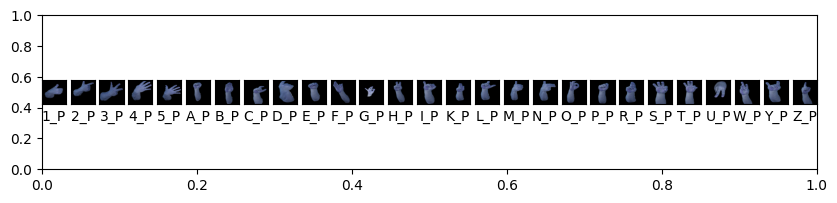

In [142]:
show_image(train_path)

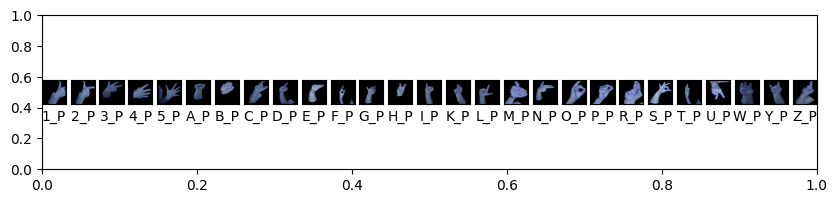

In [143]:
show_image(val_path)

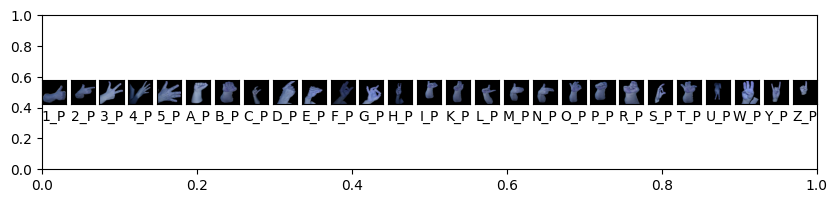

In [144]:
show_image(test_path)

## Data augment

Because we have small data, and hands are symmetric, we can flip the images to increase the dataset size. We can also apply other transformations like rotation, zoom, etc. to further augment the dataset. We will use the ImageDataGenerator class from Keras to apply these transformations.

In [145]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # normalize pixel values to [0,1]
    horizontal_flip=True, # flip along y-axis
    width_shift_range=0.1, # shift up to 10%
    height_shift_range=0.1, # shift up to 10%
    brightness_range=[0.5, 1.5], # adjust brightness
    zoom_range = [0.7, 1.7], # zoom in/out
)

test_datagen = ImageDataGenerator(
    rescale = 1./255 # normalize pixel values to [0,1]
)

In [146]:
train_data = train_datagen.flow_from_directory(train_path, target_size = (224, 224), batch_size = 32, class_mode ="categorical")
val_data = test_datagen.flow_from_directory(val_path, target_size = (224, 224), batch_size = 32, class_mode ="categorical")
test_data = test_datagen.flow_from_directory(test_path, target_size = (224, 224), batch_size = 32, class_mode ="categorical")
train_data

Found 628 images belonging to 27 classes.
Found 134 images belonging to 27 classes.
Found 136 images belonging to 27 classes.


# Resnet50
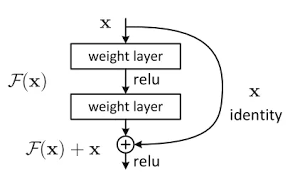

**The deeper the CNN, the easier it get to Vanish Gradient. So Resnet50 will help solve that**

We create a shortcut so the first input can maintain at some point in the network



In [123]:
def ResNet50_HGR1(input_shape = (224, 224, 3)): # input_shape = (224, 224, 3) 3 is for RGB
  input = Input(shape = input_shape)
  based_model = tf.keras.applications.ResNet50(include_top=False, weights = None, input_tensor=input).output

  x = GlobalAveragePooling2D()(based_model) 
  x = Dense(128, activation="relu", kernel_initializer= "he_normal")(x)
  x = Dropout(0.2)(x)
  output = Dense(27, activation= "softmax", kernel_initializer='he_normal')(x) # 27 classes
  model = Model(inputs = input, outputs = output)
  # model = Model(inputs = [input1, input2], outputs = [output,output1])
  model.summary()
  return model

In [124]:
resnet50 = ResNet50_HGR1()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [125]:
resnet50.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(min_lr=0.0001), ModelCheckpoint("Data/output/checkpoint/resnet50/resnet50_{epoch:}_{val_accuracy:}.keras", monitor="val_accuracy", save_best_only=True)]

In [ ]:
steps_per_epoch = 869//64 + 1
validation_step = 339//64 + 1
history = resnet50.fit(train_data, batch_size=64, validation_batch_size=64, epochs = 10, validation_data=val_data, callbacks=my_callback, initial_epoch=0)

# Transfer Learning
The best weights are saved in the checkpoint folder. However, it took me 1,000 epochs, which is way too long. Additionally, since the dataset is too small, it might not be sufficient for the model to learn effectively. I will try using transfer learning to see if it can improve the model's performance.

The reasons for applying transfer learning to this problem:
+ Small dataset: Only 24 pictures for each pose in the test set.
+ ResNet50: A complex model that works best with large datasets but not with small ones.
In the best case, the model we use for transfer learning has been trained on a similar dataset. I have chosen ImageNet for this case. By using ImageNet weights, we can eliminate the fully connected layers and some higher-level features. This approach is suited for a small dataset that is different from the one the model was originally trained on.

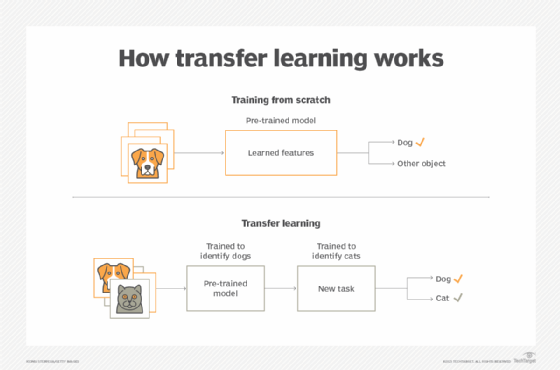

In [ ]:
base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# Load the ResNet50 model pre-trained on ImageNet, excluding the top (fully connected) layers
# The model will be used as a base for transfer learning

In [72]:
# freeze the base model
base.trainable = False

#input = Input(shape=(224, 224, 3))
x = base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x) #0.4
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x) #0.6
output = Dense(27, activation= "softmax", kernel_initializer='he_normal')(x)
transfer = Model(inputs = base.input, outputs = output)
transfer.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [73]:
transfer.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(min_lr=0.001), ModelCheckpoint("Data/output/checkpoint/transfer/resnet50_{epoch:}_{val_accuracy:}.keras", monitor="val_accuracy", save_best_only=True)]

In [74]:
steps_per_epoch = 869//128 + 1
validation_step = 339//128 + 1
history = transfer.fit(train_data, batch_size=128, validation_batch_size=128, epochs = 1000, validation_data=val_data, callbacks=my_callback, initial_epoch=700)

Epoch 701/1000
26/26 [==============================] - 8s 239ms/step - loss: 4.2811 - accuracy: 0.0528 - val_loss: 3.3306 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 702/1000
26/26 [==============================] - 6s 209ms/step - loss: 3.7230 - accuracy: 0.0983 - val_loss: 3.3093 - val_accuracy: 0.0640 - lr: 0.0010
Epoch 703/1000
26/26 [==============================] - 6s 208ms/step - loss: 3.5407 - accuracy: 0.1081 - val_loss: 3.3062 - val_accuracy: 0.0400 - lr: 0.0010
Epoch 704/1000
26/26 [==============================] - 6s 213ms/step - loss: 3.3010 - accuracy: 0.1278 - val_loss: 3.3764 - val_accuracy: 0.0520 - lr: 0.0010
Epoch 705/1000
26/26 [==============================] - 5s 209ms/step - loss: 3.2190 - accuracy: 0.1351 - val_loss: 3.3461 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 706/1000
26/26 [==============================] - 6s 210ms/step - loss: 3.2473 - accuracy: 0.1462 - val_loss: 3.3333 - val_accuracy: 0.0400 - lr: 0.0010
Epoch 707/1000
26/26 [========================

KeyboardInterrupt: 

The best result is saved in the checkpoint folder

# Fine-tuning
+ Unfreeze the base model for fine-tuning. But becareful, it can lead to overfitting.
+ We can base on val_loss and val_acc to know when to stop training

In [152]:
# First unfreeze all layer and put trainable = True
transfer = load_model("Data/output/checkpoint/transfer/resnet50_855_0.6840000152587891.keras")
for layer in transfer.layers:
    string = layer.name.split("_")
    # Freeze layers that are not batch normalization layers
    if "bn" not in string:
        layer.trainable = False
    # Unfreeze all BatchNormalization layers
    if not(isinstance(layer, keras.layers.BatchNormalization)):
        layer.trainable = True
transfer.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [153]:
#transfer = load_model("Data/output/checkpoint/transfer/resnet50_855_0.6840000152587891.keras")
transfer.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1, factor=0.1, min_lr=0.000001), ModelCheckpoint("Data/output/checkpoint/finetune/resnet_freeze1_{epoch:}_{val_accuracy:}.keras", monitor="val_accuracy", save_best_only=True)]

In [95]:
steps_per_epoch = 869//64 + 1
validation_step = 339//64 + 1
history = transfer.fit(train_data, batch_size=64, validation_batch_size=64, epochs = 400, validation_data=val_data, callbacks=my_callback, initial_epoch=120)

Epoch 121/400
26/26 [==============================] - 10s 266ms/step - loss: 16.6228 - accuracy: 0.0737 - val_loss: 3.5313 - val_accuracy: 0.0640 - lr: 1.0000e-05
Epoch 122/400
26/26 [==============================] - 6s 220ms/step - loss: 4.5734 - accuracy: 0.0479 - val_loss: 3.4856 - val_accuracy: 0.0320 - lr: 1.0000e-05
Epoch 123/400
26/26 [==============================] - 6s 224ms/step - loss: 3.8116 - accuracy: 0.0356 - val_loss: 3.4935 - val_accuracy: 0.0200 - lr: 1.0000e-05
Epoch 124/400
26/26 [==============================] - 6s 224ms/step - loss: 3.6626 - accuracy: 0.0479 - val_loss: 3.4206 - val_accuracy: 0.0440 - lr: 1.0000e-05
Epoch 125/400
26/26 [==============================] - 6s 223ms/step - loss: 3.6345 - accuracy: 0.0516 - val_loss: 3.4747 - val_accuracy: 0.0200 - lr: 1.0000e-05
Epoch 126/400
26/26 [==============================] - 6s 224ms/step - loss: 3.5928 - accuracy: 0.0479 - val_loss: 3.5342 - val_accuracy: 0.0200 - lr: 1.0000e-05
Epoch 127/400
26/26 [=====

# Conclusion
Since I masked the hands, the model works better with less noisy background. However, due to the small dataset, we expect some inaccuracies. Below are the test predictions, accuracy score, and a webcam demo that you can try.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np

dict = train_data.class_indices

model = load_model("Data/output/checkpoint/finetune/resnet_freeze1_375_0.9480000138282776.keras")
image = load_img("Data/output/test/B_P/B_P_hgr1_id01_1.jpg")
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = input_arr * 1./255
result = model.predict(np.array([input_arr]))
idx = np.argmax(result)
print(f"Predicted class: { list(dict)[idx]}")

1/1 [==============================] - 0s 484ms/step
Predicted class: B_P


In [139]:
# Evaluate the model on the test dataset
model = load_model("Data/output/checkpoint/finetune/resnet_freeze1_375_0.9480000138282776.keras")
loss, accuracy = model.evaluate(test_data)
print(f"Test accuracy: {accuracy * 100:.2f}%")
print(f"Test loss: {loss:.4f}")

5/5 [==============================] - 1s 95ms/step - loss: 0.0864 - accuracy: 0.9632
Test accuracy: 96.32%
Test loss: 0.0864


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from IPython.display import display, clear_output
from PIL import Image


model = load_model("Data/output/checkpoint/finetune/resnet_freeze1_375_0.9480000138282776.keras")
class_dict = train_data.class_indices  # Class indices dictionary


cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)

try:
    while True:
        # Capture a frame from the webcam
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Preprocess only for prediction
        frame_resized = cv2.resize(frame, (224, 224))  # Resize for model input
        input_arr = tf.keras.preprocessing.image.img_to_array(frame_resized)  # Convert to array
        input_arr = input_arr * 1./255  # Normalize
        input_arr = np.expand_dims(input_arr, axis=0)  # Add batch dimension

        # Make a prediction
        result = model.predict(input_arr)
        idx = np.argmax(result)
        predicted_class = list(class_dict.keys())[idx]

        # Display the prediction on the original frame
        cv2.putText(frame, f"Predicted: {predicted_class}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Display in notebook, convert to RGB only for display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(frame_rgb)

        # Display frame in Jupyter
        clear_output(wait=True)
        display(pil_img)

except KeyboardInterrupt:
    print("Interrupted")

# Release the webcam and close the display window
cap.release()
cv2.destroyAll


Interrupted


AttributeError: module 'cv2' has no attribute 'destroyAll'